## SpaRED Library Quick Start DEMO

This demonstration is a step by step on how to use the SpaRED library to train a gene expression prediction model with pre-trained weights. In this tutorial we will illustrate how to:

* Load a SpaRED dataset and save it in an AnnData object.
* Prepare the data for training a pretrained model for gene expression prediction.
* Initialize a pretrained model.
* Train the model using pytorch lightning.

In [2]:
import os
import sys
from pathlib import Path
import pathlib

currentdir = os.getcwd()
parentdir = str(Path(currentdir).parent)
sys.path.append(parentdir)
print(parentdir)

import spared

/media/SSD4/dvegaa/SpaRED/spared


### Load Datasets

The `datasets` file has a function to get any desired dataset and return the adata as well as the parameter dictionary. This function returns a filtered and processed adata. This function has a parameter called *visualize* that allows for all visualizations if set to True. The fuction also saves the raw_adata (not processed) in case it is required. 

We will begin by loading a dataset and setting the *visualize* parameter as False since no images are required for the functions analized in this DEMO.

In [3]:
from spared.datasets import get_dataset

#get dataset
data = get_dataset("vicari_mouse_brain", visualize=False)

/home/dvegaa/anaconda3/envs/H2ST/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading vicari_mouse_brain dataset with the following data split:
train data: ['V11L12-038_A1', 'V11L12-038_B1', 'V11L12-038_C1', 'V11L12-038_D1', 'V11L12-109_A1', 'V11L12-109_B1', 'V11L12-109_C1', 'V11L12-109_D1']
val data: ['V11T16-085_A1', 'V11T16-085_B1', 'V11T16-085_C1', 'V11T16-085_D1']
test data: ['V11T17-101_A1', 'V11T17-101_B1']
Parameters already saved in /media/SSD4/dvegaa/SpaRED/spared/spared/processed_data/vicari_data/vicari_mouse_brain/2024-08-11-18-40-39/parameters.json
Loading main adata file from disk (/media/SSD4/dvegaa/SpaRED/spared/tutorials/processed_data/vicari_data/vicari_mouse_brain/2024-08-11-18-40-39/adata.h5ad)...
The loaded adata object looks like this:
AnnData object with n_obs × n_vars = 43804 × 128
    obs: 'in_tissue', 'array_row', 'array_col', 'patient', 'slide_id', 'split', 'unique_id', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbol', 'exp_frac', 'glob_exp_frac', 'n_cells_by_counts', 'mean_counts', 'pct

### Prepare data

To train a pretrained model for gene expression prediction, we must first prepare the data. This involves using Dataloaders, a component commonly used in machine learning frameworks like PyTorch to handle the loading of data in an efficient and flexible manner. The function `get_pretrain_dataloaders` receives the following parameters as input:

* **adata (ad.AnnData):** AnnData object to process.
* **layer (str):** The layer to use for pre-training. Default is set to `c_t_log1p`.
* **batch_size (int):** The batch size of the loaders. Default is set to 128.
* **shuffle (bool):** Whether to shuffle the data in the loaders. Default is set to True.
* **cuda (bool):** Whether to use CUDA in the loaders. Default is set to False.

##### <u>Returns:</u>

This function returns train, validation, and test dataloaders as a tuple to be used for training a pretrained model.


In [33]:
from spared.dataloaders import get_pretrain_dataloaders

# Declare train and test loaders
train_dataloader, val_dataloader, test_dataloader = get_pretrain_dataloaders(
    adata=data.adata,
    layer = 'c_t_log1p',
    batch_size = 265,
    shuffle = True,
    use_cuda = True
)

Percentage of imputed observations with transformer model: 27.503%


### Initialize model

The SpaRED library provides a function to  initilize a model with pretrained weights for gene expression prediction. The function `ImageBackbone` class receives the following inputs:

* **args (argparse):** Argument parser with specific variables required to initialize the model.
* **latem_dim (int):** Latent dimensions used as output feature dimensions in the last layer of the defined model.

##### <u>Returns:</u>

The function returns the initialized model. The backbone used for pretrained weights is defined in the argparse parameters. In this demo, we will use ShuffleNetV2. You can check the available backbones in the documentation of the SpaRED library.

In [34]:
from spared.models import ImageBackbone
import argparse
import torch

# Define argparse variables
test_args = argparse.Namespace()
arg_dict = vars(test_args)
input_dict = {
    'img_backbone': 'ShuffleNetV2',
    'img_use_pretrained': True,
    'average_test': False,
    'optim_metric': 'MSE',
    'robust_loss': False,
    'optimizer': 'Adam',
    'lr': 0.0001,
    'momentum': 0.9,
}

for key,value in input_dict.items():
    arg_dict[key]= value


# Declare device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageBackbone(args=test_args,  latent_dim=data.adata.n_vars).to(device)
model


ImageBackbone(
  (test_transforms): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (criterion): MSELoss()
  (encoder): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2

### Training the model

Now we will use PyTorch Lightning to train the model. First, we must define a `ModelCheckpoint` callback to monitor the validation mean squared error (val_MSE) and save only the best model based on this metric. Then, we initialize a `Trainer` and define various parameters. In this case our model will run for a maximum of 1000 training steps, perform validation every 10 steps, log progress every 10 steps, and use one GPU for training. Additionally, the trainer displays a progress bar and a model summary during training. This setup ensures efficient model training and validation, with automatic saving of the best model based on the specified validation metric.

In [35]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

# Define checkpoint callback to save best model in validation
checkpoint_callback = ModelCheckpoint(
    monitor=f'val_MSE', # Choose your validation metric
    save_top_k=1, # Save only the best model
    mode='min'
)

# Define the trainier and fit the model
trainer = Trainer(
    max_steps=1000,
    val_check_interval=10,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback],
    check_val_every_n_epoch=None,
    devices=[6],
    enable_progress_bar=True,
    enable_model_summary=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Now, we must begin the training process using PyTorch Lightning's `Trainer` with the `fit` method. The `fit` method is called with the specified model, training data loader (train_dataloader), and validation data loader (val_dataloader). This setup allows the Trainer to manage the training loop, including feeding the model with training data, performing validation at specified intervals, and utilizing the previously defined configurations and callbacks for efficient training and model checkpointing.

In [36]:
trainer.fit(
    model=model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



  | Name            | Type         | Params
-------------------------------------------------
0 | test_transforms | Normalize    | 0     
1 | criterion       | MSELoss      | 0     
2 | encoder         | ShuffleNetV2 | 472 K 
-------------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.892     Total estimated model params size (MB)


Epoch 11:  11%|█         | 10/90 [01:21<10:55,  0.12it/s, v_num=8]         

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 11:  11%|█         | 10/90 [01:22<10:56,  0.12it/s, v_num=8]


### Evaluate models performance

After training, the path to the best model is obtained from the `checkpoint_callback`. We can use the best model to evaluate performance on the test set (if available). We load the model from the `checkpoint_callback` path and use the `trainer.test` method to evaluate the model's performance on the test data. 

In [37]:
# Load the best model after training
best_model_path = checkpoint_callback.best_model_path
print(best_model_path)
model = ImageBackbone.load_from_checkpoint(best_model_path)

# Test model if there is a test dataloader
if not (test_dataloader is None):
    trainer.test(model, dataloaders=test_dataloader)

/media/SSD4/dvegaa/SpaRED/spared/tutorials/lightning_logs/version_8/checkpoints/epoch=11-step=1000.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 26/26 [00:16<00:00,  1.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Global          -3.3897759914398193
        test_MAE             1.071439504623413
        test_MSE            1.8195239305496216
      test_PCC-Gene        -0.033114705234766006
     test_PCC-Patch          0.808578610420227
      test_R2-Gene          -1.5282227993011475
      test_R2-Patch         0.2539464235305786
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [38]:
print(best_model_path)

/media/SSD4/dvegaa/SpaRED/spared/tutorials/lightning_logs/version_8/checkpoints/epoch=11-step=1000.ckpt


### Visualize predictions

After evaluating the model's performance, it's helpful to visualize the predictions made by the model. This allows us to understand how well the model is performing and identify any potential areas for improvement. The get_predictions function is designed to extract and accumulate predictions from the model across the entire test dataset.

In this function, the model's `test_step` method is called to generate predictions (`expression_pred`), ground truth values (`expression_gt`), and a mask (`mask`). The `ImageBackbone` model used in this tutorial has this function implemented. This method allows for efficient extraction of predictions, which can then be used for visualization and further analysis.

In [39]:
from tqdm import tqdm

def get_predictions(dataloader, model, device="cuda")->None:
    # Set model to eval mode
    model=model.to(device)
    model.eval()

    glob_expression_pred = None
    # Get complete predictions
    with torch.no_grad():
        for b in tqdm(range(0,len(test_dataloader.dataset))):
            batch = dataloader.dataset[b]
            expression_pred, expression_gt, mask = model.test_step(batch)
            expression_pred = expression_pred.cpu()

            # Concat batch to get global predictions and IDs
            glob_expression_pred = expression_pred if glob_expression_pred is None else torch.cat((glob_expression_pred, expression_pred))

    return glob_expression_pred

# Put complete predictions in a single dataframe
glob_expression_pred = get_predictions(test_dataloader, model)


100%|██████████| 6730/6730 [42:37<00:00,  2.63it/s]  


After extracting the predictions, this code integrates them into the existing AnnData object, allowing for further analysis or visualization within the same data structure. The predictions are added to the layers attribute of the AnnData object under the key `"predictions,{layer}"`.

In [40]:
import pandas as pd  
        
# Put complete predictions in a single dataframe
adata_test = data.adata[data.adata.obs["split"] == "test"]
pred_matrix = glob_expression_pred
glob_ids = adata_test.obs['unique_id'].tolist()
pred_df = pd.DataFrame(pred_matrix, index=glob_ids, columns=adata_test.var_names)
pred_df = pred_df.reindex(adata_test.obs.index)

# Add layer to adata
layer = "c_t_log1p"
adata_test.layers[f'predictions,{layer}'] = pred_df
adata_test

AnnData object with n_obs × n_vars = 6730 × 128
    obs: 'in_tissue', 'array_row', 'array_col', 'patient', 'slide_id', 'split', 'unique_id', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbol', 'exp_frac', 'glob_exp_frac', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_length', 'd_log1p_moran', 'log1p_avg_exp', 'd_log1p_avg_exp', 'c_log1p_avg_exp', 'c_d_log1p_avg_exp'
    uns: 'spatial', 'spatial_neighbors'
    obsm: 'patches_scale_1.0', 'spatial'
    layers: 'c_d_deltas', 'c_d_log1p', 'c_deltas', 'c_log1p', 'c_t_deltas', 'c_t_log1p', 'counts', 'd_deltas', 'd_log1p', 'deltas', 'log1p', 'mask', 'tpm', 'noisy_c_t_log1p', 'predictions,c_t_log1p'
    obsp: 'spatial_connectivities', 'spatial_distances'

Finally, we will be using a plotting function from our `spared` library to plot the prediction images.

### Funtion: `log_pred_image`

The `log_pred_image` function is designed to visualize the predictions made by a model for a specific gene expression dataset. It generates multiple visual outputs, including histograms for performance metrics (like PCC, R2, MSE, and MAE) and detailed spatial plots of gene expression across different slides. This function helps assess how well the model's predictions align with the ground truth data by visualizing the predicted and actual gene expression across spatial dimensions.

##### <u>Parameters:</u>
* **adata (ad.AnnData):** The annotated data object containing the dataset, including both the ground truth and predicted layers.
* **n_genes (int, optional):** The number of genes to select for detailed visualization. Default is 2.
* **slides (dict, optional):** A dictionary specifying the slides to be used for visualization. If not provided, the first slide from each partition is selected.
* **save_path (str, optional):** The directory path where the generated images will be saved. Default is './'.

##### <u>Returns:</u>
This function does not return any value. It generates and saves several visualizations, including histograms of performance metrics and spatial plots of selected genes, at the specified save path.

### Explanation
The `log_pred_image` function is an extensive visualization tool tailored for gene expression data. It processes and logs model predictions, comparing them against the ground truth through various plots and metrics. This function is particularly useful for assessing the quality of the model's predictions and for understanding the spatial distribution of gene expression across different conditions or slides in a dataset.


In [42]:
from spared.plotting import log_pred_image

# Create folder to save prediction images
os.makedirs('./prediction_images', exist_ok=True)
log_pred_image(adata_test, n_genes=2, slides={}, save_path='./prediction_images')



### Understanding the plots

#### Visualization of Correlation Analysis
The function provides correlation matrices of the top 50 genes, which are used to compare the relationships between genes in the predicted and ground truth gene expression data. 

The left matrix represents the correlations between the gene expression predictions made by the model, while right matrix shows the correlation between gene expression levels in the actual (ground truth) data. The bright yellow diagonal line indicates a perfect correlation (value of 1.0) between a gene and itself. The colors and patterns away from the diagonal indicate the correlation between different genes. Yellowish colors suggest a high correlation (close to 1.0), while purple or blueish colors suggest a lower correlation (closer to 0.4 or lower). 

Patterns such as blocks or stripes may indicate groups of genes that are predicted to be similarly expressed. Additionally, any discrepancies between the ground truth matrix and the predictions matrix suggest areas where the model's predictions diverge from the true gene expression relationships. For instance, differences in block patterns or the intensity of correlations (color) indicate potential inaccuracies in the model's predictions.



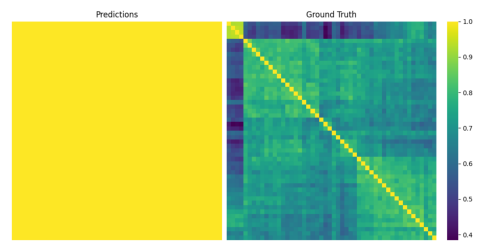

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as im

# Load the correlations saved image
image_path = os.path.join("./prediction_images", "correlations.png")
img = im.imread(image_path)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Spatial Visualization of Gene Expression
The function  identifies the top and bottom performing genes based on PCC. For the selected genes, the function generates detailed spatial plots that compare the ground truth gene expression with the model's predictions. It visualizes the gene expression across selected slides, allowing for a direct comparison between the predicted and actual data.

These plots are arranged in a grid, where each row corresponds to a different slide, and each column shows the original image, the gene expression ground truth, the fixed scale gene expression prediction and the variable scale gene expression prediction.

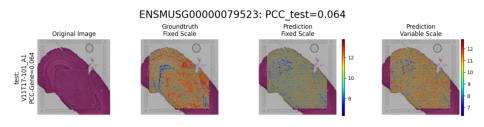

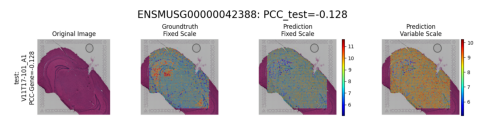

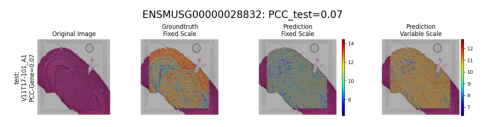

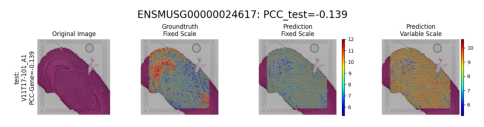

In [44]:
import glob

comparisons = glob.glob("./prediction_images/*comparison.png")

# Load the comparison saved images
for path in comparisons:
    img = im.imread(path)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


#### Visualization Performance Metrics
For each available data partition (train, validation, test), the function calculates detailed performance metrics like PCC, R2, MSE, and MAE. These metrics are then visualized through histograms. Each histogram represents the distribution of these metrics across all genes in the dataset, providing a global view of the model's performance.

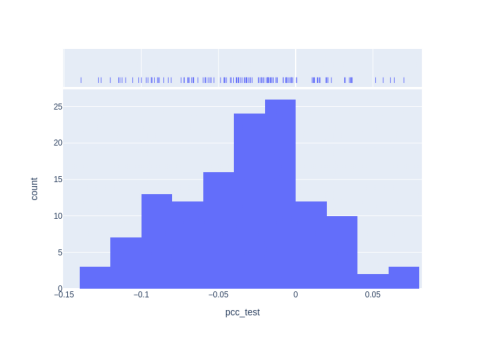

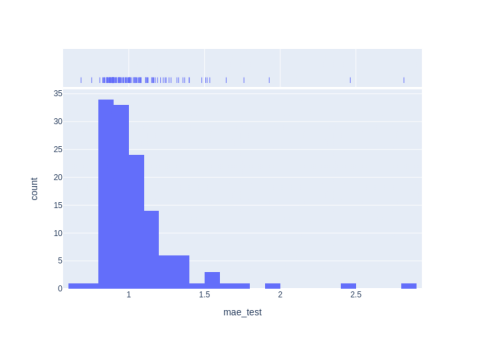

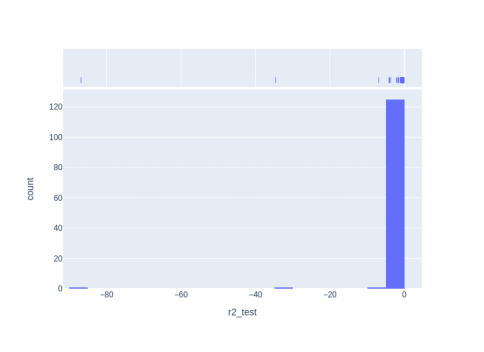

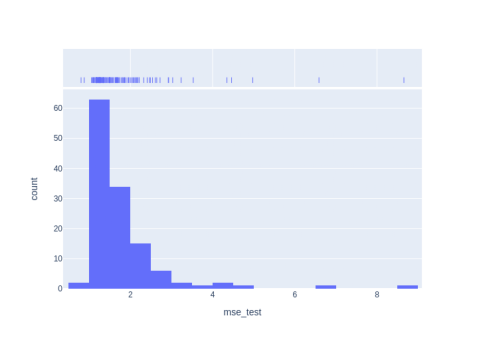

In [45]:
metrics = glob.glob("./prediction_images/*test.png")

# Load the metric's histograms saved images
for path in metrics:
    img = im.imread(path)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#### Mean and Variance Visualization

Finally, the function plots the mean and variance of gene expression for both the ground truth and predictions. This comparison helps to assess whether the model accurately captures not just the mean expression levels but also the variability across different genes. Scatter plots are used to compare the mean and variance of gene expression between the ground truth and the predictions. These plots help to identify any systematic biases or discrepancies in the model's predictions.

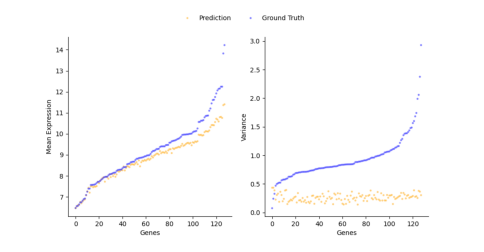

In [46]:
# Load the mean and variance saved image
image_path = os.path.join("./prediction_images", "mean_variance.png")
img = im.imread(image_path)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()